# TODO: Use evalAllQueries fn to get and save ROC curve for whatever alignment we have, Generate Figure, Debug everything

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb

In [52]:
def evalAllQueries(pairsFile, annotFile, pathsRoot, editDur, scoring_collar = 0.1, numThresholds = 1000, \
                   saveFile = None, hop_sec = 512 / 22050):
    insertionAttributions = []
    deletionAttributions = []
    replacementAttributions = []
    
    annotList = list(map(lambda x: x.split(), open(annotFile, 'r').readlines())) # I doubt this works but lets give it a go...
    
    with open(pairsFile, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            
            # Find correct annotations
            queryId = os.path.basename(parts[0])[:-4] # [:-4] here to get rid of .wav
            annot = findAnnot(annotList, queryId)
            
            # Find path
            #pathBasename = queryId + '__' + os.path.basename(parts[1])  # This will need to change based on file structure
            pathFile = pathsRoot + '/' + queryId[:-4] + '.pkl' # [:-4] here to get rid of _160
            path = pkl.load(open(pathFile, 'rb'))

            tamperType, theseAttributions = evalQuery(path, annot, scoring_collar, editDur, hop_sec)
            
            # Add new costs and GT to
            if tamperType == "N":
                continue
            elif tamperType == "I":
                insertionAttributions += theseAttributions
            elif tamperType == "D":
                deletionAttributions += theseAttributions
            else:
                replacementAttributions += theseAttributions

    # Get ROCs
    insertionROC = calc_ROC(np.array(insertionAttributions), numThresholds)
    deletionROC = calc_ROC(np.array(deletionAttributions), numThresholds)
    replacementROC = calc_ROC(np.array(replacementAttributions), numThresholds)
    
    if saveFile is not None:
        outdir = os.path.dirname(saveFile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        pkl.dump([insertionROC, deletionROC, replacementROC], open(saveFile, 'wb'))
    
    return [insertionROC, deletionROC, replacementROC]

In [53]:
def findAnnot(annotList, queryId):
    for annot in annotList:
        if annot[1] == queryId:
            return annot
    
    print("Error: Annotations not found")
    return None

In [54]:
def evalQuery(hyp, annot, scoring_collar, editDur, hop_sec):
    
    tamperType = annot[0]
    attributions = []
    path = hyp['wp']
    dists = hyp['dist']
    size = hyp['size']
    
    # set up boundaries list (in seconds, relative to modified query)
    # In form matchingRegionStart, tamperStart, tamperEnd, matchingRegionEndEnd
    # This will depend on tamperType
    if tamperType == "N":
        return tamperType, attributions
    
    elif tamperType == "I":
        insertionStart = float(annot[5])
        insertionEnd = insertionStart + editDur
        offset = 0
        
        # I use +/- inf here to signal that the matching region extends to the first and last frames, and no scoring
        # collar is needed
        boundaries = [-float('inf'), insertionStart, insertionEnd, float('inf')]
        query_length = path[0,0]
        startFrame = 0 # startFrame only used for deletions where the path is in the complete wrong place

    elif tamperType == "D": # For deletions, also flip query and reference
        queryPath = np.copy(path[:,0])
        refPath = np.copy(path[:,1])
        path[:,0] = refPath
        path[:,1] = queryPath
        
        deletionStart = float(annot[5])
        deletionEnd = deletionStart + editDur
        offset = float(annot[3])
        matchEnd = float(annot[4]) - offset # This should be 10
        query_length = path[0,0]
        startFrame = path[-1,0]
        
        # Here, the matching region starts and ends at the boundaries of the query recording
        boundaries = [offset, deletionStart + offset, deletionEnd + offset, matchEnd + offset]
        
        print(startFrame, query_length, offset / hop_sec)
        
        
    
    else: # replacement
        replacementStart = float(annot[5])
        replacementEnd = float(annot[6])
        offset = 0
        
        # Again, the matching region will extend all the way to the first and last frames
        boundaries = [-float('inf'), replacementStart, replacementEnd, float('inf')]
        query_length = path[0,0]
        startFrame = 0
    
    gt = getAttributionsGT(query_length, offset, boundaries, scoring_collar, hop_sec, startFrame)

    # Impute cost scores
    # Interpolate here to fill in the frames that the path jumps over
    costs = np.interp(np.arange(startFrame, query_length), path[:,0][::-1], dists[::-1])
    for i in range(gt.shape[0]):
        if gt[i] >=0:
            attributions.append([gt[i], costs[i]])
         
    return tamperType, attributions

In [55]:
def getAttributionsGT(query_length, offset, boundaries, scoring_collar, hop_sec, startFrame = 0):
    offsetFrames = int(np.round(offset / hop_sec))
    
    gt = np.zeros(query_length - startFrame)
        
    # Get the GT for each frame
    # For now, just represent each frame with a single timestamp (at where the frame begins)
    for frame in range(startFrame, query_length):
        t_query = frame * hop_sec - offset
        if withinCollar(t_query, boundaries, scoring_collar):
            gt[frame-startFrame] = -1
        elif t_query < boundaries[0] or (t_query > boundaries[1] and t_query < boundaries[2]) or t_query > boundaries[3]:
            gt[frame-startFrame] = 1 # Non-matching region
        else:
            gt[frame-startFrame] = 0
            
    return gt

In [56]:
def withinCollar(t_query, boundaries, scoring_collar):
    for t_boundary in boundaries:
        if np.abs(t_query - t_boundary) < scoring_collar:
            return True
    return False

In [57]:
def calc_ROC(attributions, numThresholds):
    '''
    Calculates ROC curve for attributions based on number of thresholds
    
    '''
    
    costs = attributions[:,1]
    gt = attributions[:,0]
        
        
    # Get minimum and max for thresholds
    thresholdMin = np.min(costs)
    thresholdMax = np.max(costs)
    
    thresholds = np.linspace(thresholdMin, thresholdMax, numThresholds)
    ROC = np.ones((numThresholds,3))*-1
    
    # For each threshold, calculate false positive and false negative (miss) rate
    for i, threshold in enumerate(thresholds):
        FPCountTot = 0
        FNCountTot = 0
        TrueNegCount = 0
        TruePosCount = 0
        
        FPCount, FNCount = calcFPFN(costs, gt, threshold)

        TrueNegCount += np.sum(gt == 1) # Note: Positive means match
        TruePosCount += np.sum(gt == 0)

        FPCountTot += FPCount
        FNCountTot += FNCount
        
        # Threshold, False Positive, False Negative
        ROC[i,:] = [threshold, FPCountTot/TrueNegCount, FNCountTot/TruePosCount]
    
    return ROC

In [58]:
def calcFPFN(costVec, gtAttribution, threshold):
    '''
    Calculate number of false positives and false negatives
    '''
    
    # If cost is lower than threshold, then we consider sample in
    # non tampered region (nontampered = 0, tampered = 1)
    costHypVec = (costVec >= threshold).astype(int)

    diffVec = (costHypVec - gtAttribution)

    FPCount = np.sum((diffVec == -1).astype(int))
    FNCount = np.sum((diffVec == 1).astype(int))

    return FPCount, FNCount

In [59]:
editTimes = [2]
benchmark = 'train'
systems = ["D3"]

for editTime in editTimes:
    for sys in systems:
        pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/%s_%ss.pairs" % (benchmark, str(editTime))
        annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_%ssec.gt" % (str(editTime))
        pathsRoot = "/mnt/data0/agoutam/TamperingDetection/hyp/%s" % (sys)
        saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/%s/%s_%ss" % (sys, benchmark, str(editTime))
        
        evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

5108 5376 6978.179003906249
3385 3697 4664.479394531249
15 328 20.88720703125
4247 4559 5852.896874999999
2838 3079 3909.3960937499996
1632 1880 2159.7802734375
5253 5504 7238.084765625001
1885 2144 2524.85419921875
4534 4845 6247.212890625
137 384 187.252734375
6434 6683 8779.56064453125
1521 1792 2095.56826171875
3411 3722 4700.13837890625
3572 3884 4922.9208984375
6301 6546 8682.40283203125
979 1223 1348.71064453125
4402 4652 5981.191699218751
845 1157 1163.86962890625
6795 7107 9363.79951171875
6887 7172 9489.6826171875
5727 6038 7890.92841796875
3174 3433 4373.43662109375
2558 2803 3432.26337890625
2081 2321 2769.6867187499997
3257 3569 4488.20859375
1511 1762 2081.87314453125
1556 1867 2142.8551757812497
1596 1839 2198.32470703125
1106 1353 1523.5171874999999
2023 2333 2786.5687499999995
4796 5107 6608.7123046875
1793 2062 2410.857421875
4994 5260 6881.7533203125
5510 5821 7592.21982421875
131 442 180.06064453125
1095 1407 1508.185546875
1135 1405 1563.2244140625
4101 4413 5650.7

### Figures

In [60]:
def plotAttribution(timesToPlot, systemsToPlot, benchmark):
    fig, axs = plt.subplots(1, len(timesToPlot), figsize = (10, 7))

    for i, plotTime in enumerate(timesToPlot):
        x = np.arange(len(systemsToPlot))
        numBars = 3
        width = 0.75 / numBars
        axs[i].grid(zorder=0)
        insertions = []
        deletions = []
        replacements = []
        for j, plotSys in enumerate(systemsToPlot):
            
            ROCfile = "/mnt/data0/tshaw/TamperingDetection/eval/%s/%s_%ss" % (plotSys, benchmark, str(editTime))

            
            ROCs = pkl.load(open(ROCfile, 'rb'))
            insertions.append(findEER(ROCs[0]))
            deletions.append(findEER(ROCs[1]))
            replacements.append(findEER(ROCs[2]))

        axs[i].bar(x - width, np.array(insertions) * 100, width, zorder = 3)
        axs[i].bar(x, np.array(deletions) * 100, width, zorder = 3)
        axs[i].bar(x + width, np.array(replacements) * 100, width, zorder = 3)
        
        
        axs[i].set_xlabel("System")
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(systemsToPlot)
        axs[i].set_ylim(0,80)
        axs[i].set_title("L = " + str(plotTime))

    plt.legend(["Insertions", "Deletions", "Replacements"], loc = (1.1, 0.5))
    fig.suptitle("Attribution Error Rates", fontsize = 'x-large')
    axs[0].set_ylabel("Equal Error Rate (%)", fontsize = "large")
    fig.tight_layout()

In [61]:
def findEER(ROC):
    '''
    Calculates Equal Error Rate based on ROC
    
    '''
    minDiff = np.inf
    savedFP = 0
    savedFN = 0

    for rate in ROC:
        FP = rate[1]
        FN = rate[2]

        if np.abs(FP - FN) < minDiff:
            minDiff = np.abs(FP - FN)
            savedFP = FP
            savedFN = FN
            
    return (savedFP + savedFN) / 2

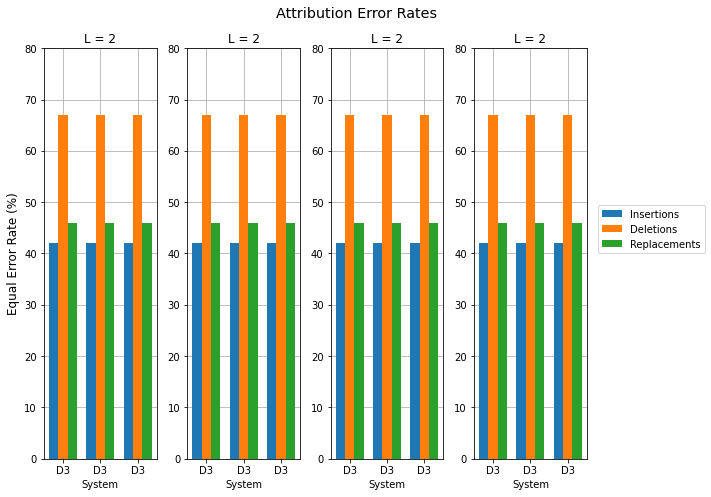

In [62]:
timesToPlot = [2, 2, 2, 2]
systemsToPlot = ["D3", "D3", "D3"]
benchmark = "train"

plotAttribution(timesToPlot, systemsToPlot, benchmark)

In [15]:
ROCfile = "/mnt/data0/tshaw/TamperingDetection/eval/D3/train_2s"
ROCs = pkl.load(open(ROCfile, 'rb'))

In [16]:
ROCs

[array([[1.12133908e+00, 0.00000000e+00, 1.00000000e+00],
        [1.62090673e+00, 0.00000000e+00, 9.99935600e-01],
        [2.12047439e+00, 0.00000000e+00, 9.99710201e-01],
        ...,
        [4.99190287e+02, 1.00000000e+00, 3.21998970e-05],
        [4.99689855e+02, 1.00000000e+00, 3.21998970e-05],
        [5.00189423e+02, 1.00000000e+00, 3.21998970e-05]]),
 array([[1.42926109e+00, 0.00000000e+00, 1.00000000e+00],
        [1.91040877e+00, 9.66582037e-06, 1.00000000e+00],
        [2.39155645e+00, 8.69923833e-05, 1.00000000e+00],
        ...,
        [4.81133499e+02, 9.99996778e-01, 0.00000000e+00],
        [4.81614647e+02, 9.99996778e-01, 0.00000000e+00],
        [4.82095795e+02, 9.99996778e-01, 0.00000000e+00]]),
 array([[1.26732278e+00, 0.00000000e+00, 1.00000000e+00],
        [1.75711324e+00, 1.47994672e-04, 9.99870029e-01],
        [2.24690370e+00, 8.87968033e-04, 9.99133524e-01],
        ...,
        [4.89588412e+02, 1.00000000e+00, 4.33238021e-05],
        [4.90078203e+02, 1.00

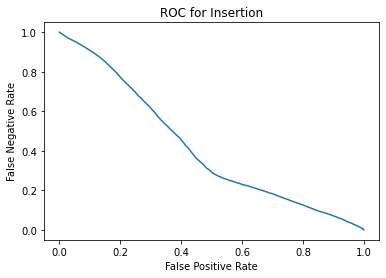

In [27]:
ROC = ROCs[0]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Insertion");

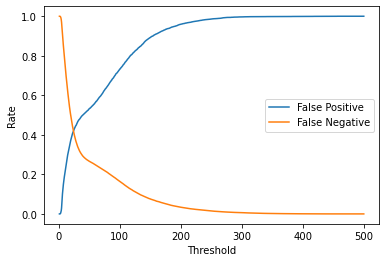

In [28]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

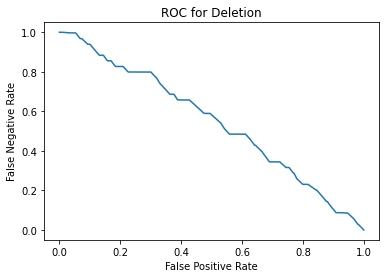

In [29]:
ROC = ROCs[1]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Deletion");

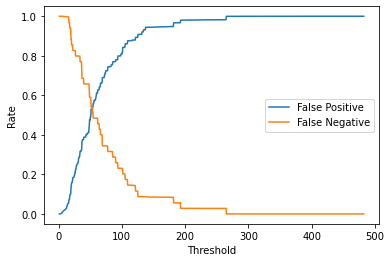

In [30]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

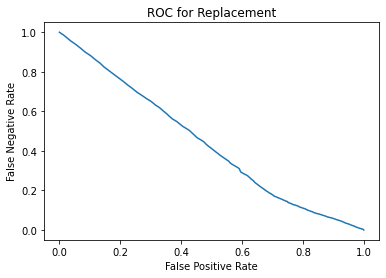

In [31]:
ROC = ROCs[2]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Replacement");

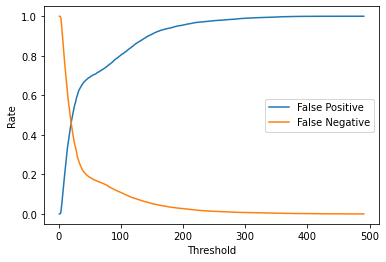

In [32]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);